In [1]:
import numpy as np
import matplotlib.pylab as plt
import copy

import apoc
import pyclesperanto_prototype as cle
import napari
import tifffile

C:\Users\naly008c\.conda\envs\axolotl\Lib\site-packages\pytools\persistent_dict.py:52: RecommendedHashNotFoundWarning: Unable to import recommended hash 'siphash24.siphash13', falling back to 'hashlib.sha256'. Run 'python3 -m pip install siphash24' to install the recommended hash.
  warn("Unable to import recommended hash 'siphash24.siphash13', "


In [2]:
from image_analysis.read_files import get_paths, change_paths
from image_analysis.preprocess import mask

# GPU device

In [3]:
device = cle.get_device()
print("Device name:", device.name)

Device name: Intel(R) UHD Graphics 620


# Information about the image

In [4]:
channels = {
            "fgf":    0, 
            "shh":    1, 
            "bright": 2, 
            "dapi":   3, 
            "dusp":   4, 
            "auto":   5
           }


# Voxel size
pixel_size_x, pixel_size_y, pixel_size_z = 2*0.9019, 2*0.9019, 2*3.9991

# Fixed values for image preprocessing

In [5]:
downsample = 2                 # downsampling level while image loading (the same along all axis)
pixel_size_aim_user_def = 8e-6 # pixel size for binning
sigma = 1.25                      # for gauss filter before thresholding

# Load image

In [6]:
image_folder_tif = r'example_raw_images/'
sample = '2_5cm_6dpa_noif'

img_paths = get_paths(image_folder_tif, channel='6d',suffix='tif')
img_paths = change_paths(img_paths, include='noif')

In [7]:
img_paths = sorted(
    img_paths,
    key = lambda c: c.split('/c')[1].split('_')[0]
)

In [8]:
img_paths

['example_raw_images/c1_hcr21_20240722_6d_noif.tif',
 'example_raw_images/c2_hcr21_20240722_6d_noif.tif',
 'example_raw_images/c3_hcr21_20240722_6d_noif.tif',
 'example_raw_images/c4_hcr21_20240722_6d_noif.tif',
 'example_raw_images/c5_hcr21_20240722_6d_noif.tif',
 'example_raw_images/c6_hcr21_20240722_6d_noif.tif']

In [9]:
img = []
for path in img_paths:
    i = tifffile.imread(path)
    img.append(i[::downsample, ::downsample, ::downsample])
img = np.array(img).astype( np.uint16 )

channels = list(channels.keys())
img = dict(zip(channels, img))

In [10]:
del img['dapi']
del img['bright']

In [11]:
for key in img.keys():
    img[key] = np.flip(img[key], 2)
    # take 2d slice
    mid_slice = img[key].shape[0] // 2
    img[key] = img[key][mid_slice]

# Plot channels

In [12]:
pixel_size_x, pixel_size_y = downsample*pixel_size_x, downsample*pixel_size_y

In [13]:
height, width = img['dusp'].shape
extent = [0, width * pixel_size_x, height * pixel_size_y, 0]  # Flip y-axis to keep origin at top-left

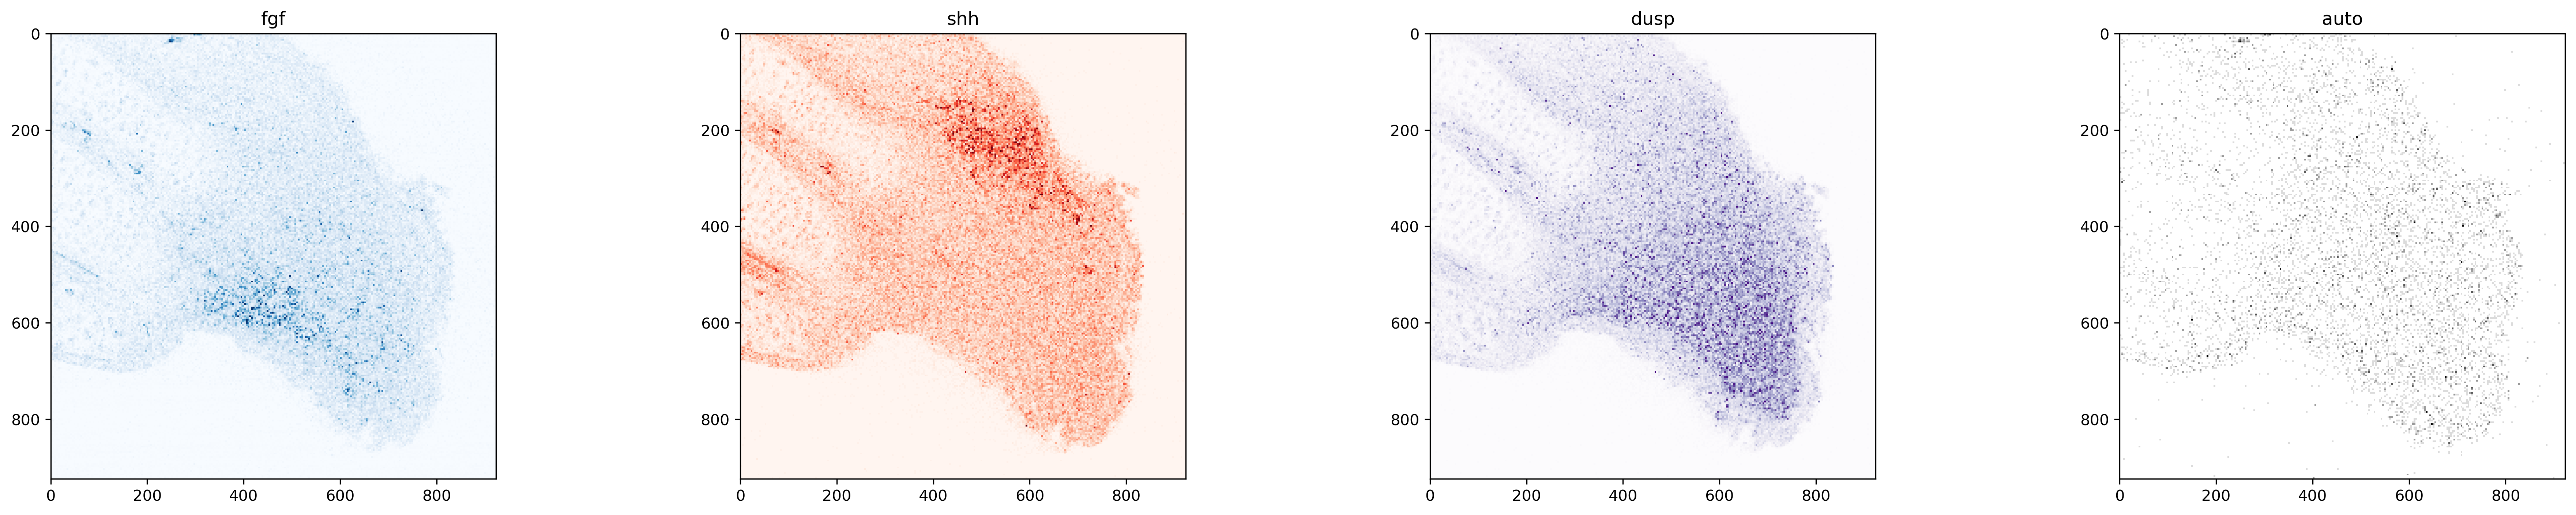

In [14]:
# Define colors (colormap names or color overlays if needed)
color_map = {
    'fgf': 'Blues',
    'shh': 'Reds',
    'dusp': 'Purples',
    'auto': 'Grays'
}

# Plotting
default_figsize = plt.rcParams["figure.figsize"]
fig, axes = plt.subplots(1, len(img), figsize=(default_figsize[0] * len(img), default_figsize[1]), dpi=300)

if len(img) == 1:
    axes = [axes]  # Ensure axes is iterable

for ax, (key, image) in zip(axes, img.items()):
    ax.imshow(2*image, cmap=color_map.get(key, 'gray'), extent=extent)
    ax.set_title(key)

plt.tight_layout()
#plt.savefig('fig/channels.pdf')
plt.show()

# APOC segmenter for tissue mask

In [15]:
manual_annotations = tifffile.imread('segmenters/manual_annotations_for_tissue_mask_2_5cm_6dpa_noif.tif')

In [16]:
# define features (standart)
features = apoc.PredefinedFeatureSet.small_quick.value

# this is where the model will be saved
cl_filename = "segmenters/tissue_mask_2_5cm.cl"

apoc.erase_classifier(cl_filename)
clf = apoc.ObjectSegmenter(opencl_filename=cl_filename, positive_class_identifier=2)
clf.train(features, manual_annotations, img['dusp'])

C:\Users\naly008c\.conda\envs\axolotl\Lib\site-packages\pyclesperanto_prototype\_tier9\_imshow.py:35: UserWarning: cle.imshow is deprecated, use stackview.imshow instead.
  warnings.warn("cle.imshow is deprecated, use stackview.imshow instead.")


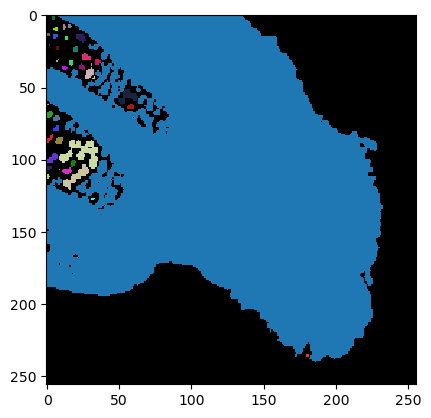

In [17]:
segmentation_result = clf.predict(features=features, image=img['dusp'])
cle.imshow(segmentation_result, labels=True)

In [18]:
tissue_mask = np.array( segmentation_result > 0 ).astype( np.uint16 )

In [19]:
from scipy import ndimage
import skimage 

tissue_mask[0, :] = 1
tissue_mask[:, 0] = 1

tissue_mask = ndimage.binary_fill_holes(tissue_mask)

r = 5
selem = skimage.morphology.disk(radius=r)
# Apply binary opening
tissue_mask = skimage.morphology.binary_opening(tissue_mask, selem)
        
# Apply binary closing
tissue_mask = skimage.morphology.binary_closing(tissue_mask, selem)

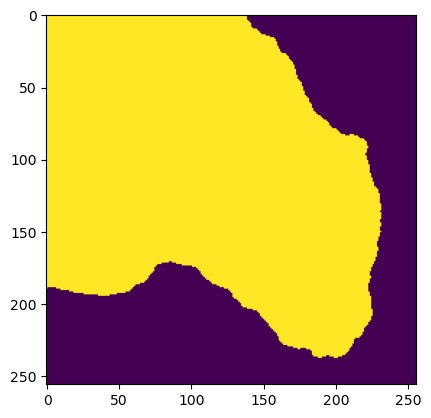

In [20]:
plt.imshow( tissue_mask )

# Thresholding

*ChatGPT generated summary*

## 🔍 Overview of Thresholding and Machine Learning-Based Pixel Classification in Image Analysis

Image segmentation often starts by separating foreground (objects of interest) from the background. The most common approaches for this are **global thresholding**, **local (adaptive) thresholding**, and **machine learning-based pixel classification**. Each method has its strengths and is suited for different types of images.

---

### 🟦 Global Thresholding

**Global thresholding** applies a single threshold value to the entire image. Every pixel is compared to this one value: if the pixel intensity is above the threshold, it is classified as foreground; otherwise, it is background.

This approach is simple and fast and works well for images with uniform lighting and good contrast between foreground and background.

A classic example is **Otsu's method**, which automatically determines the optimal global threshold by minimizing the variance within each class (foreground and background).

---

### 🟩 Local (Adaptive) Thresholding

**Local thresholding** (also known as adaptive thresholding) computes a different threshold value for each pixel or small region in the image. These thresholds are based on local statistics such as the mean and standard deviation within a defined window around each pixel.

This method is especially useful for images with non-uniform lighting, shadows, or background noise, where a single global threshold would fail.

A commonly used local method is **Sauvola thresholding**, which adjusts the threshold for each region based on its local contrast.

---

### 🟨 Machine Learning-Based Pixel Classification

**Machine learning-based pixel classification** takes a fundamentally different approach. Instead of thresholding pixel intensities, it trains a model to classify each pixel based on a set of image features.

These features can include:
- Raw intensity
- Filtered responses (e.g., Gaussian blur, gradients, Laplacian)
- Texture and local statistics
- Multiscale information from the surrounding neighborhood

Importantly, pixel coordinates (x, y) are typically **not** included as features, unless explicitly desired. The classifier focuses on the **local appearance** of pixels rather than their position.

The process involves:
1. The user manually labels a small set of pixels (e.g., marking object and background).
2. The system extracts feature vectors for the labeled pixels.
3. A supervised machine learning model (e.g., Random Forest) is trained on these features.
4. The trained model is applied to all pixels in the image, assigning a class label to each one.

Unlike thresholding, this method does **not** produce a numeric threshold. Instead, it directly outputs a **label map**, where each pixel is classified based on its features.

A popular tool in this category is **APOC (Artificial Pixel Object Classifier)**, which is built on top of scikit-learn and integrates well with the napari viewer for interactive workflows.

---

### 🧭 Summary

| Method                     | Output                   | Adapts to Local Features | Requires User Labels |
|----------------------------|---------------------------|---------------------------|-----------------------|
| Global Thresholding        | One global threshold      | ❌                        | ❌                    |
| Local Thresholding         | Threshold per region/pixel| ✅                        | ❌                    |
| ML-Based Classification    | Class label per pixel     | ✅                        | ✅                    |

Each method serves a different purpose. For quick, clean images, global thresholding is sufficient. For images with uneven lighting, local methods are more robust. For complex cases where object and background are not easily separable by intensity, machine learning classification offers the most flexibility and accuracy.


# Final figure for thresholding

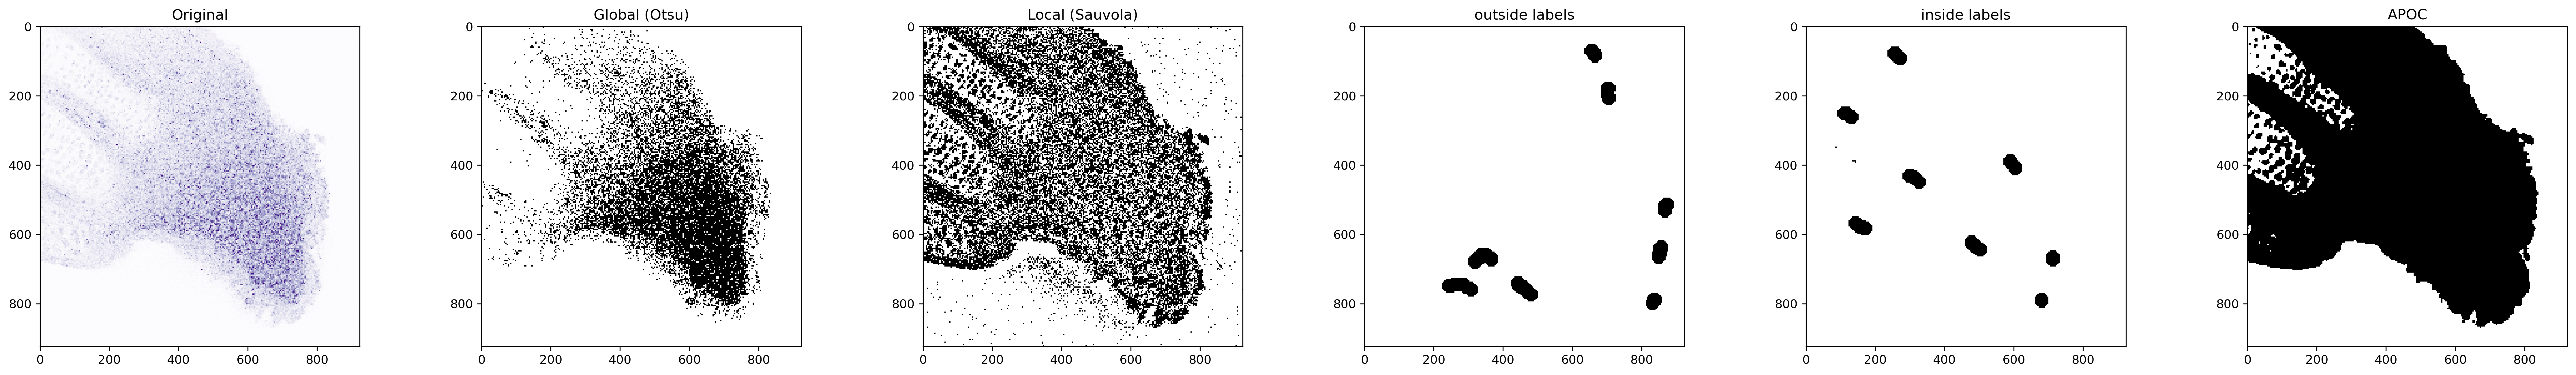

In [21]:
from skimage import data, filters
from skimage.filters import threshold_otsu, threshold_sauvola

# Load example image
image = copy.deepcopy( img['dusp'] )

# Global thresholding with Otsu
global_thresh = threshold_otsu(image)
binary_global = image > global_thresh

# Local thresholding with Sauvola
window_size = 25
local_thresh = threshold_sauvola(image, window_size=window_size)
binary_local = image > local_thresh

# Plotting
fig, axes = plt.subplots(1, 6, figsize=(default_figsize[0] * 6, default_figsize[1]), dpi=300)
axes[0].imshow( 2 * image, cmap='Purples', extent=extent)
axes[0].set_title('Original')

axes[1].imshow(binary_global, cmap='Grays', extent=extent)
axes[1].set_title('Global (Otsu)')

axes[2].imshow(binary_local, cmap='Grays', extent=extent)
axes[2].set_title('Local (Sauvola)')

axes[3].imshow(manual_annotations == 1, cmap='Grays', extent=extent)
axes[3].set_title('outside labels')

axes[4].imshow(manual_annotations == 2, cmap='Grays', extent=extent)
axes[4].set_title('inside labels')

axes[5].imshow(segmentation_result > 0, cmap='Grays', extent=extent)
axes[5].set_title('APOC')

#axes[5].imshow(tissue_mask, cmap='Grays', extent=extent)
#axes[5].set_title('tissue_mask')

plt.tight_layout
plt.savefig('fig/thresholding.pdf')
plt.show()